# Package import

In [1]:
import numpy as np
import pandas as pd
import elo_tools as et
from glob import glob
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.gridspec as gridspec
import itertools

import statsmodels.formula.api as smf

font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 16}

mpl.rc('font', **font)

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# Hierarchy stability analysis

In [5]:
path = 'Data/behaviour/raw/'
files = glob(f'{path}*.xls')


Cs = []
Ss = []
Ts = []
day = []
cages = []
for file in files:
    
    cage = file.split('/')[-1].split('.')[0]
    print(cage)
    try:
        ratings, ranks, C, S, T, _ = et.process_group_elo(file, plotting=False, accurate_dates=False)
    except Warning:
        print('Problem - skipping.')
        continue
        
    C = np.insert(C, 0, np.nan)
    S = np.insert(S, 0, np.nan)
    
    Cs.append(C)
    Ss.append(S)
    Ts.append(T)
    days = np.arange(len(T))
    day.append(days)
    cages.append([cage] * len(days))

Cs = np.concatenate(Cs)
Ss = np.concatenate(Ss)
Ts = np.concatenate(Ts)
day = np.concatenate(day)
cages = np.concatenate(cages)
    
results = pd.DataFrame(dict(zip(['cage', 'C', 'S', 'T', 'day'], np.stack([cages, Cs, Ss, Ts, day]))))
results['T'] = results['T'].replace({'1.0': True, '0.0': False, 'nan': np.nan})

results = results.astype({'C': float,
                'S': float,
                'T': 'boolean',
                'day': int})

C00752347
C00696883
C00628128
C00646579
C00513224
C00547699
C00668983
C00601300
C00601303
C00601296
C00651855
C00668982
C00522267
C00563520
C00752360
C00628151
C00752362
C00578173
C00657909
C00524055
C00628100
C00569952
C00578164
C00663455
C00696890
C00523680
C00613521
C00706603
C00628140
C00529901
C00617264
C00578264
C00601297
C00669063
C00525578
C00555201
C00569112
C00542606
C00686996
C00578098
C00569117
C00564066
C00706597
C00669059
C00504862
C00601308


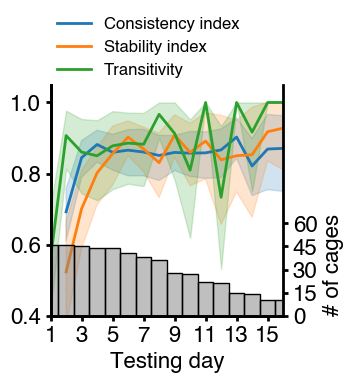

In [7]:
fig, ax1 = plt.subplots(figsize=[3,3])

# Create line plots on the first y-axis
sns.lineplot(data=results, x='day', y='C', label='Consistency index', ax=ax1)
sns.lineplot(data=results, x='day', y='S', label='Stability index', ax=ax1)
sns.lineplot(data=results, x='day', y='T', label='Transitivity', ax=ax1)

plt.xlim(0, 15)
ax1.set_ylim(0.4, 1.05)
ax1.set_xlabel('Testing day')
ax1.set_ylabel('')

ax2 = ax1.twinx()
sns.histplot(data=results, x='day', bins=np.arange(-0.5, results.day.max()), ax=ax2, color='gray', alpha=0.5)
ax2.spines['right'].set_visible(True)
ax2.set_ylim(0, 150)
ax2.set_yticks(np.arange(0, 66, 15), np.arange(0, 66, 15))
ax2.set_ylabel('# of cages', loc='bottom')



plt.xticks(np.arange(0, 15, 2), np.arange(1, 16, 2))

ax1.legend(loc=[0,1], prop={'size': 12}, frameon=False, ncol=1)

plt.savefig('../Plots/Behaviour/Tube test stability stats.png', dpi=300, bbox_inches='tight')

# Example hierarchy

In [ ]:
cage = f'{path}C00578173.xls'
df = pd.read_excel(cage)

ratings, ranks, C, S, T, _ = et.process_group_elo(cage, plotting=False, accurate_dates=False)

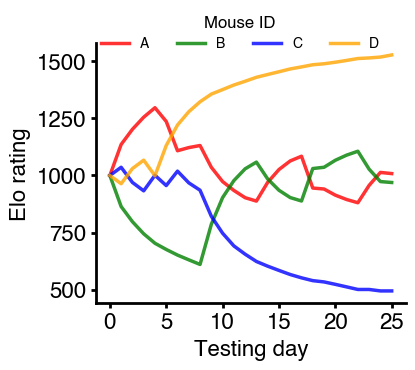

In [12]:
colors = {'A': 'r',
         'B': 'g',
         'C': 'b',
         'D': 'orange'}

plt.figure(figsize=[4,6])

gs = gridspec.GridSpec(4, 1, height_ratios=[5, 1, 1, 1])
ax1 = plt.subplot(gs[0])
'''ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])'''

plt.subplots_adjust(hspace=0.15)

for name, animal in ratings.items():
    ax1.plot(animal, label=name, linewidth=2.5, color=colors[name], alpha=0.8)
    
ax1.set_xticks([])
ax1.set_ylabel('Elo rating')

names = ratings.keys()
legend = ax1.legend(ncol = len(names), loc=(0, 0.95), prop={'size': 10}, title = 'Mouse ID', frameon=False)
legend.get_title().set_fontsize(12)

ax1.set_xlabel('Testing day')
ax1.set_xticks(np.arange(0, len(animal) + 1, 5), np.arange(0, len(animal) + 1, 5))

plt.savefig('../Plots/Example hierarchy.png', dpi=300, bbox_inches='tight')

# Winner effect analysis

In [13]:
def winning_history_effect(df):
    '''
    df = tube test record (pandas DataFrame)

    Returns:
        ww = number of consequtive victories
        wl = number of victories followed by a loss
        lw = number of losses followed by a victory
        ll = number of consequtive losses
    '''

    ww, wl, lw, ll = np.zeros(4, dtype = int)

    dates = np.unique(df['Date'])
    names = np.unique(df[['Winner', 'Loser']])

    for date in dates:
        session = df[df['Date'] == date][['Winner', 'Loser']]

        for name in names:
            tests = np.where(np.sum(session == name, axis=1))[0]
            tests = session.iloc[tests]

            result_repeats = tests[:-1].reset_index(drop=True) == tests[1:].reset_index(drop=True)

            ww += result_repeats.sum()[0]
            ll += result_repeats.sum()[1]

            result_differences = tests[:-1].reset_index(drop=True) != tests[1:].reset_index(drop=True)
            result_differences = np.where(result_differences.sum(axis=1) == 2)[0]
            result_differences = tests.iloc[result_differences]['Winner'] == name

            wl += result_differences.sum()
            lw += result_differences.shape[0] - result_differences.sum()

    return int(ww), int(wl), int(lw), int(ll)

In [ ]:
files = glob(f'{path}/*.xls')

history_matrix = np.zeros(4, dtype=int)
for file in files:
    print(file)
    
    df = pd.read_excel(file)
    
    history_matrix += winning_history_effect(df)

f_obs = pd.DataFrame(history_matrix.reshape(2,2), index=['Prior win', 'Prior Loss'], columns=['Future win', 'Future loss'])


Data/behaviour/raw/C00752347.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00696883.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00628128.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00646579.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00513224.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00547699.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00668983.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00601300.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00601303.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00601296.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00651855.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00668982.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00522267.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00563520.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00752360.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00628151.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00752362.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00578173.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00657909.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00524055.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00628100.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00569952.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00578164.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00663455.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00696890.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00523680.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00613521.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00706603.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00628140.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00529901.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00617264.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00578264.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00601297.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00669063.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00525578.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00555201.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00569112.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00542606.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00686996.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00578098.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00569117.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00564066.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00706597.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00669059.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00504862.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Data/behaviour/raw/C00601308.xls


/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ww += result_repeats.sum()[0]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ll += result_repeats.sum()[1]
/var/folders/t2/d6jltp_d10z243mdl6vkhq5989mt6g/T/ipykernel_3664/3157891401.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

Theoretical prediction

For each mouse there is a known number of wins and losses, but their order is random, so for each mouse all the possible orderings of the its known tube test outcomes are enumerated. For each of these combinations the consecutive outcomes and switches are calculated and then averaged across combinations to find the mean scenario. 

In [15]:
### Calculates the expected ratio of ww and ll to wl and lw outcomes

mice = 4

combs = []
for n in range(mice):
    outcomes = ['Win'] * n + ['Loss'] * (mice - n - 1)
    
    scores = itertools.permutations(outcomes)
    scores = np.unique(list(scores), axis=0)
    combs.append(scores)
     
repeated = []
outcome_switches = []

for comb in combs:
    temp_repeated = []
    temp_switches = []
    for score in comb:
        temp_repeated.append(np.array(score[:-1] == score[1:]).sum())
        temp_switches.append(np.array(score[:-1] != score[1:]).sum())
    
    repeated.append(np.mean(temp_repeated))
    outcome_switches.append(np.mean(temp_switches))
    
print("Expected ratio for a round-robin design with %s mice: \n" % mice)
print(np.sum(repeated) / np.sum(outcome_switches))

Expected ratio for a round-robin design with 4 mice: 

2.0


In [21]:
print(history_matrix)
tests = history_matrix.sum().sum()
f_exp = np.array([tests/3, tests/6, tests/6, tests/3])
f_exp = pd.DataFrame(f_exp.reshape(2,2), index=['Prior win', 'Prior Loss'], columns=['Future win', 'Future loss'])
f_exp

[1316  666  766 1316]


,Future win,Future loss
Prior win,1354.666667,677.333333
Prior Loss,677.333333,1354.666667


In [22]:
# Pairwise statistical tests between empirical and expected frequencies for each outcome group

from statsmodels.stats.proportion import proportions_ztest

conditions = list(zip(['Prior win', 'Prior Loss', 'Prior win', 'Prior Loss'], 
                         ['Future win', 'Future win', 'Future loss', 'Future loss']))
#corrected_comparisons = {list(conditions)}
total_tests = f_obs.sum().sum()

Ps = []
for prior, future in conditions:
    
    _, p = proportions_ztest([f_obs.loc[prior][future], f_exp.loc[prior][future]], [total_tests, total_tests])
    Ps.append(p)

from statsmodels.stats.multitest import multipletests
_, Ps, _, _ = multipletests(Ps)
Ps = dict(zip(conditions, Ps))
Ps



{('Prior win', 'Future win'): np.float64(0.7393017470209404),
 ('Prior Loss', 'Future win'): np.float64(0.03966294513437219),
 ('Prior win', 'Future loss'): np.float64(0.7393017470209404),
 ('Prior Loss', 'Future loss'): np.float64(0.7393017470209404)}

In [18]:
# Main Chi-square test testing for differences in empirical and expected frequencies of consecutive and siwtching tube test outcomes

from scipy.stats import chisquare, chi2_contingency

chi, p = chisquare(np.array(f_obs).flatten(), np.array(f_exp).flatten(), axis=None)

print(f'Chi-square p-value: {p}')

Chi-square p-value: 0.0028997987278918244


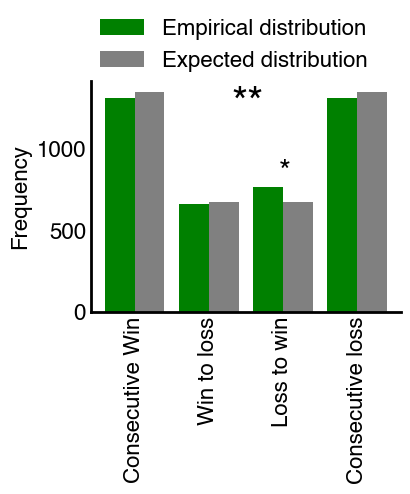

In [19]:
plt.figure(figsize=[4,3])

x = np.arange(4)

plt.bar(x, np.array(history_matrix).flatten(), width = 0.4, label = 'Empirical distribution', color='green')
plt.bar(x + 0.4, np.array(f_exp).flatten(), width = 0.4, label='Expected distribution', color='grey')

plt.xticks(x + 0.2, 
           rotation = 90,
           labels = ['Consecutive Win', 'Win to loss', 'Loss to win', 'Consecutive loss'])

plt.tick_params(length=0)
plt.ylabel('Frequency')

sig_label = ['n.s.', '*', '**', '***', '****'][(p < [0.05, 0.01, 0.001, 0.0001]).sum()]
plt.text(1.5, 1200, sig_label, fontsize=30)

plt.legend(loc=(0, 1),frameon=False)
# Stars for the significant pairwise comparison
plt.text(2.15, 800, '*', fontsize=22)

plt.savefig('../Plots/Tube test controls/Winner_effect_updated.png', dpi=300, bbox_inches = "tight")
